<h1>This is the Algorithm for calibrating the Sensor</h1>

<p> All this calculations are done for white light. Since this is only the calibration process you need to set up an pure white sheet and move sensor back and forth for calibrating</p>

<h3>Method of Calibration</h3>
<ol>
    <li> Regression equations are already done.</li>
    <li> Read many samples from the sensor. </li>
    <li> Find Refression constants using the difference between readings and calculations.</li>
    <li> Define inverse functions for Regression equations so we can find average brigtenss from intensity. </li>
</ol>

In [59]:
# import necessary files
import serial
import numpy as np 
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
%matplotlib inline

In [6]:
def readArduinoData():
    """
    DOCSTRING: this is the function for reading data from the arduino
    return   : function will return a 3xn matrix containg RGB data and averaged 1D array
    """
    
    # here finds the port which arduino connected to
    data = []
    PORT = 0
    while True:
        try:
            RGBcircuit = serial.Serial("COM"+str(PORT), baudrate=9600, timeout=1)
            break
        except:
            PORT = PORT + 1

    print("PORT Connected to COM" + str(PORT))

    # now we get 1000 samples from the sensor circuit
    for index in range(1000):
        try:
            tempData = list(map(int, RGBcircuit.readline().decode('utf-8')[:-1].split(",")))
            data.append(tempData)
        
            if index % 100 == 0:
                print("Progress -> {} %".format(index / 10))

        except UnicodeDecodeError:
            pass

        except KeyboardInterrupt:
            exit()

        except ValueError:
            exit()

    print("Progress -> 100.0%")
    
    data = np.array(data, dtype="int16")
    average = np.mean(data, axis=1)
    
    print("Closing Serial Connections...")
    
    RGBcircuit.reset_input_buffer()
    RGBcircuit.reset_output_buffer()
    RGBcircuit.flushInput()
    RGBcircuit.flushOutput()
    RGBcircuit.close()
   
    print("All Connections terminated succesfully")
    return data, average

In [44]:
data, average = readArduinoData()

PORT Connected to COM7
Progress -> 10.0 %
Progress -> 20.0 %
Progress -> 30.0 %
Progress -> 40.0 %
Progress -> 50.0 %
Progress -> 60.0 %
Progress -> 70.0 %
Progress -> 80.0 %
Progress -> 90.0 %
Progress -> 100.0%
Closing Serial Connections...
All Connections terminated succesfully


In [45]:
def smooth(y, box_pts):
    """
    DOCSTRING: this function will average neareby samples and calculate the best fitting line
    return   : smoothed cureve of y
    """
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

<h2> Regression Equations for R, G, B </h2>

$$R = 40.5785 \sqrt{I_{R} - 42.1185} - 239.378$$

$$G = 0.02052 (I_{G} + 347.788)^{1.5} - 43.2058$$

$$B = 0.02475 (I_{B} + 460.702)^{1.5} - 326.867$$



<h2> Inverse Equations for finding Intensity of each </h2>

$$I_{R} = \left(\frac{R + 239.378}{40.5785}\right) ^ {2} + 42.1185$$
<br>
$$I_{G} = \left(\frac{G + 43.2058}{0.02052}\right) ^ {\frac{2}{3}} - 347.788 $$
<br>
$$I_{B} = \left(\frac{B + 326.867}{0.02475}\right) ^ {\frac{2}{3}} - 460.702 $$

In [46]:
# this is the global regression constant that we need to find using samples
RegressionConst = np.array([0, 0, 0], dtype="float64")

In [47]:
def regressionProc(results, single = False):
    """
    DOCSTRING : This function will process given average and return R, G, B according to regression
    results   : This is the raw average. (Could be the matrix or single)
    single    : This is the switch between single and matrix mode
    """
    
#     0.02052
    if not single:
        red   = 40.5785 * np.sqrt(results[:, 3] -42.1185) - RegressionConst[0]
        green = 0.01989 * np.power(results[:, 3] + 347.788, 1.5) - RegressionConst[1]
        blue  = 0.02475 * np.power(results[:, 3] + 460.702 , 1.5) - RegressionConst[2]
    
    else:
        red   = 40.5785 * np.sqrt(results -42.1185) + RegressionConst[0]
        green = 0.02002 * np.power(results + 347.788, 1.5) + RegressionConst[1]
        blue  = 0.02475 * np.power(results + 460.702 , 1.5) + RegressionConst[2]
    
    return red, green, blue

In [48]:
def findRegressionConsts(results):
    """
    DOCSTRING : this function will calculate the regression constant
    reuslts   : this is the matxis containing original RGB values and averages
    """
    
    # get random indexes to get samples from the samples
    randomIndexes = np.random.randint(low = 21, high = results.shape[0] - 21, size = 10)
    
    diffs = []
    
    # for every random index get the difference between calculation and sample
    for index, randIndex in enumerate(randomIndexes):
        tempRow = results[randIndex]
        tempAvg = tempRow[3] # average key in the selected row
        tR, tG, tB = regressionProc(tempAvg, single=True) # do regression for the selected row
        diffs.append([tR - tempRow[0], tG - tempRow[1], tB - tempRow[2]]) # get differences between reg and real
        
    diffs = np.array(diffs, dtype="float64")
    diffs = np.mean(diffs, axis = 0)
    
    return diffs

In [97]:
def curve(x, c0 ,c1 ,c2):
    return c0 + c1*np.power(x, c2)

def cc(x, c):
    return c[0] + c[1]*np.power(x, c[2])

g = [400, 0, 2]

def getPredictions(dataColumn, averageColumn):
    c, _ = curve_fit(curve, averageColumn, dataColumn, g)
    return c

In [99]:
x = np.array([382,432,482,532,582])
y = np.array([510, 555,600,670,739])
getPredictions(y, x)

array([4.06112716e+02, 7.65847463e-06, 2.76296985e+00])

In [103]:
def processRatio(average, data):
    """
    DOCSTRING: this function will process regression compare and plot graphs for us
    average  : average array
    data     : 3xn RGB data array
    """
    
    average = average.reshape(-1, 1).astype("int16") # reshape the average
    result = np.hstack((data, average)) # connect average with the data

    # Now it is time to group the data
    results=[]
    for x in sorted(np.unique(result[...,3])):
        results.append([    np.average(result[np.where(result[...,3]==x)][...,0]),
                            np.average(result[np.where(result[...,3]==x)][...,1]), 
                            np.average(result[np.where(result[...,3]==x)][...,2]), 
                            x])

    results = np.array(results, dtype="float64")

    _ , ax = plt.subplots(1, 1, sharex=True, figsize = (18, 14))

    ax.set_ylim(150, 800)
    
    xlimits = (np.min(results[:, 3]) + 21, np.max(results[:, 3]) - 21)
    ax.set_xlim(xlimits[0], xlimits[1])

    major_xticks = np.arange(xlimits[0], xlimits[1], 50)
    minor_xticks = np.arange(xlimits[0], xlimits[1], 10)

    major_yticks = np.arange(150, 850, 50)
    minor_yticks = np.arange(150, 850, 10)


    ax.set_xlabel("Average Between RGB readings")

    ax.set_title("Average vs RGB Raw readings and Regression")
    ax.set_ylabel("RGB Raw Readings")

    ax.plot(results[:, 3], smooth(results[:, 0], 20), 'r', label="Red")
    ax.plot(results[:, 3], smooth(results[:, 1], 20), 'g', label="Green")
    ax.plot(results[:, 3], smooth(results[:, 2], 20), 'b', label="Blue")

    # find the regressing constants and assign those
    global RegressionConst
    RegressionConst = np.array([0, 0, 0], dtype="float64") # first set to zero
    RegressionConst = findRegressionConsts(results)
    #red green blue equation
    red, green, blue = regressionProc(results)

    ax.plot(results[:, 3], red,   'r--', label="Red calculated")
    ax.plot(results[:, 3], green, 'g--', label="Green calculated")
    ax.plot(results[:, 3], blue , 'b--', label="Blue calculated")
    

    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # And a corresponding grid
    ax.grid(which='both')
    ax.legend(loc = 'upper left')
    
    global r
    r = results


[235.58443568  13.17179698 350.35846453]


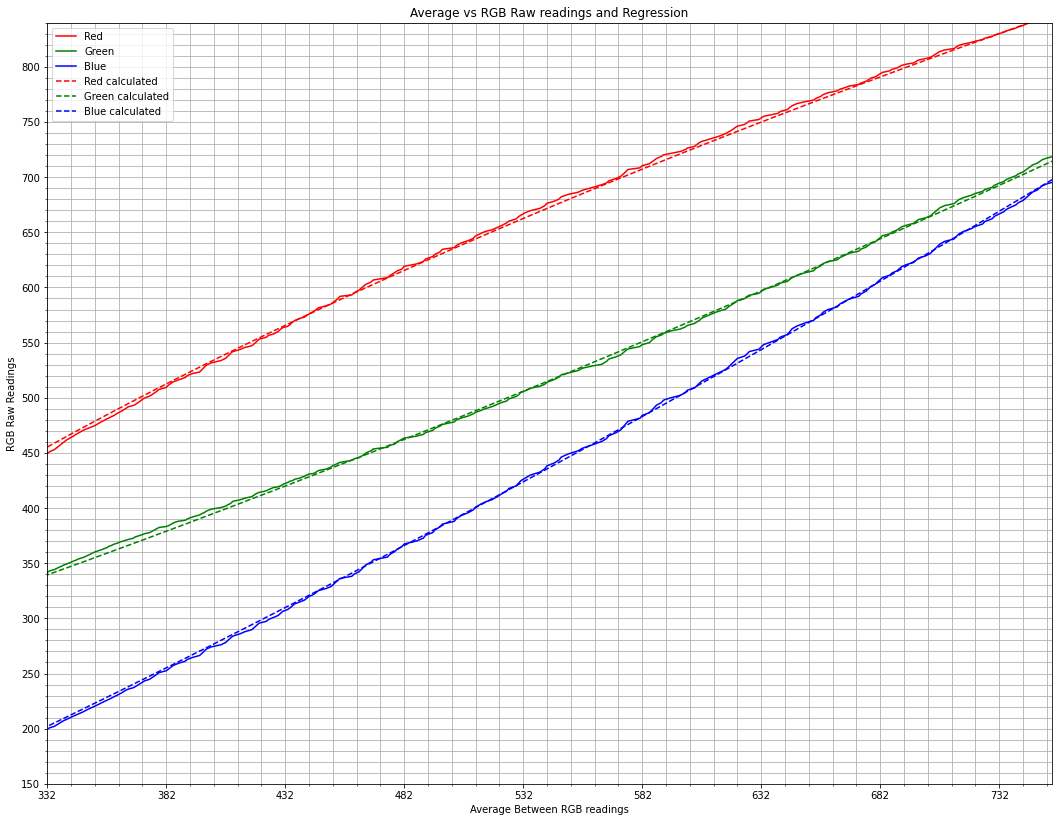

In [104]:
processRatio(average, data)
print(RegressionConst)

In [92]:
def InverteReadings(data):
    """
    DOCSTRING: this is the function to inverte given data and find corresponding intensity
    data     : data to be inverted
    return   : will return 3 arrays
    """
    
    IR = np.power((data[:, 0] + RegressionConst[0]) / 40.5785, 2) + 42.1185
    IG = np.power((data[:, 1] + RegressionConst[1]) / 0.02052, 2/3) - 347.788
    IB = np.power((data[:, 2] + RegressionConst[2]) / 0.02475, 2/3) - 460.702

    return IR, IG, IB

In [93]:
def plotReadedData(data, average):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize = (18, 14))

    t = np.arange(0, data[:, 0].shape[0], 1)

    ax[0].set_title("Original Readings without Processing")
    ax[0].set_ylabel("Light Intensity")
    ax[0].plot(t, data[:, 0], 'r--', label="Red Reading")
    ax[0].plot(t, data[:, 1], 'g--', label="Green Reading")
    ax[0].plot(t, data[:, 2], 'b--', label="Blue Reading")
    ax[0].plot(t, average, 'k', label="Average")
    ax[0].grid()
    ax[0].legend(loc = 'upper left')

    R, G, B = InverteReadings(data)

    ax[1].set_title("Readings after process with regression")
    ax[1].set_xlabel("N Samples")
    ax[1].set_ylabel("Intensity")
    ax[1].plot(t, R, 'r')
    ax[1].plot(t, G, 'g')
    ax[1].plot(t, B, 'b')
    ax[1].grid()

    plt.show()

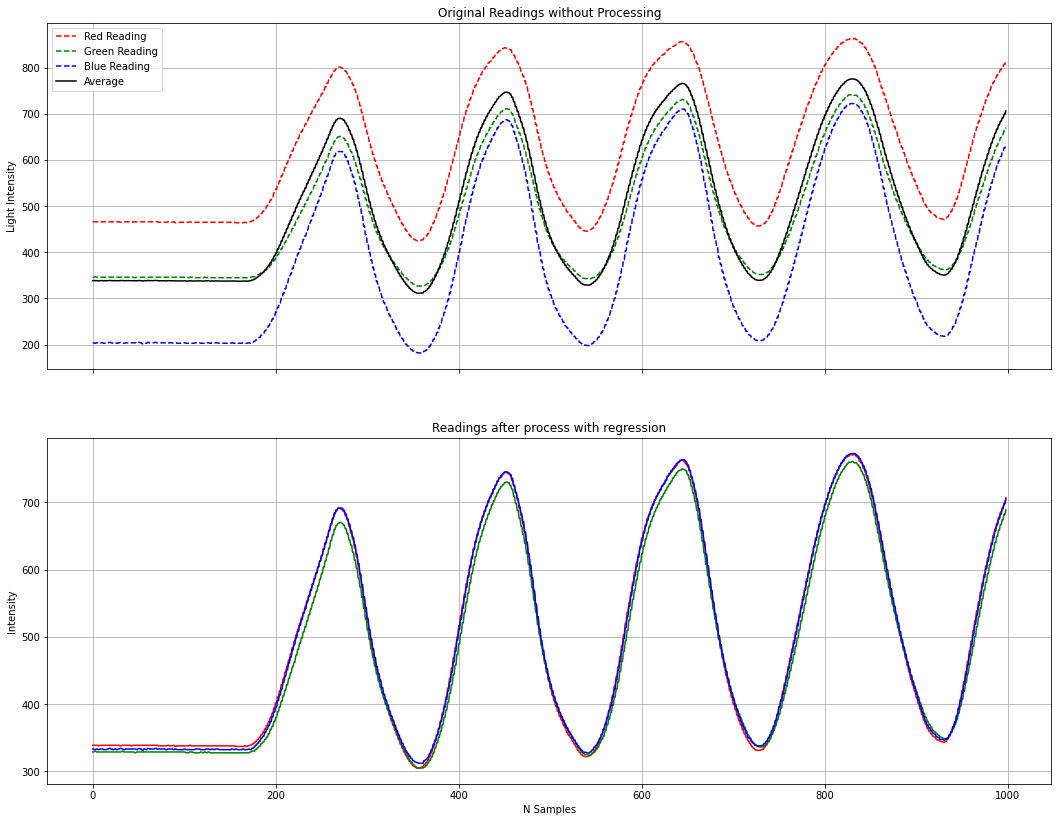

In [53]:
plotReadedData(data, average)

<h2>Now read some data using already calibrated equations</h2>

<h3>Fisrt of all we use Red paper</h3>

In [54]:
rdata, raverage = readArduinoData()

PORT Connected to COM7
Progress -> 10.0 %
Progress -> 20.0 %
Progress -> 30.0 %
Progress -> 40.0 %
Progress -> 50.0 %
Progress -> 60.0 %
Progress -> 70.0 %
Progress -> 80.0 %
Progress -> 90.0 %
Progress -> 100.0%
Closing Serial Connections...
All Connections terminated succesfully


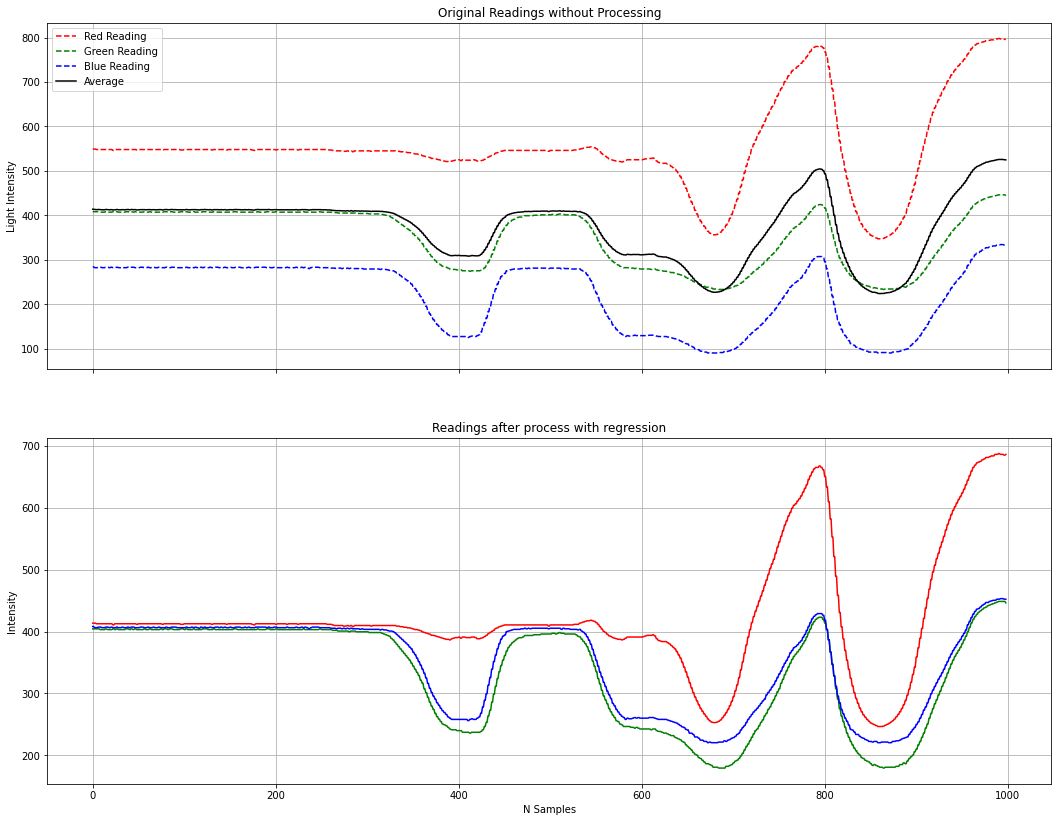

In [55]:
plotReadedData(rdata, raverage)

<h2>Then the Light green paper</h2>

In [56]:
lgdata, lgaverage = readArduinoData()

PORT Connected to COM7
Progress -> 10.0 %
Progress -> 20.0 %
Progress -> 30.0 %
Progress -> 40.0 %
Progress -> 50.0 %
Progress -> 60.0 %
Progress -> 70.0 %
Progress -> 80.0 %
Progress -> 90.0 %
Progress -> 100.0%
Closing Serial Connections...
All Connections terminated succesfully


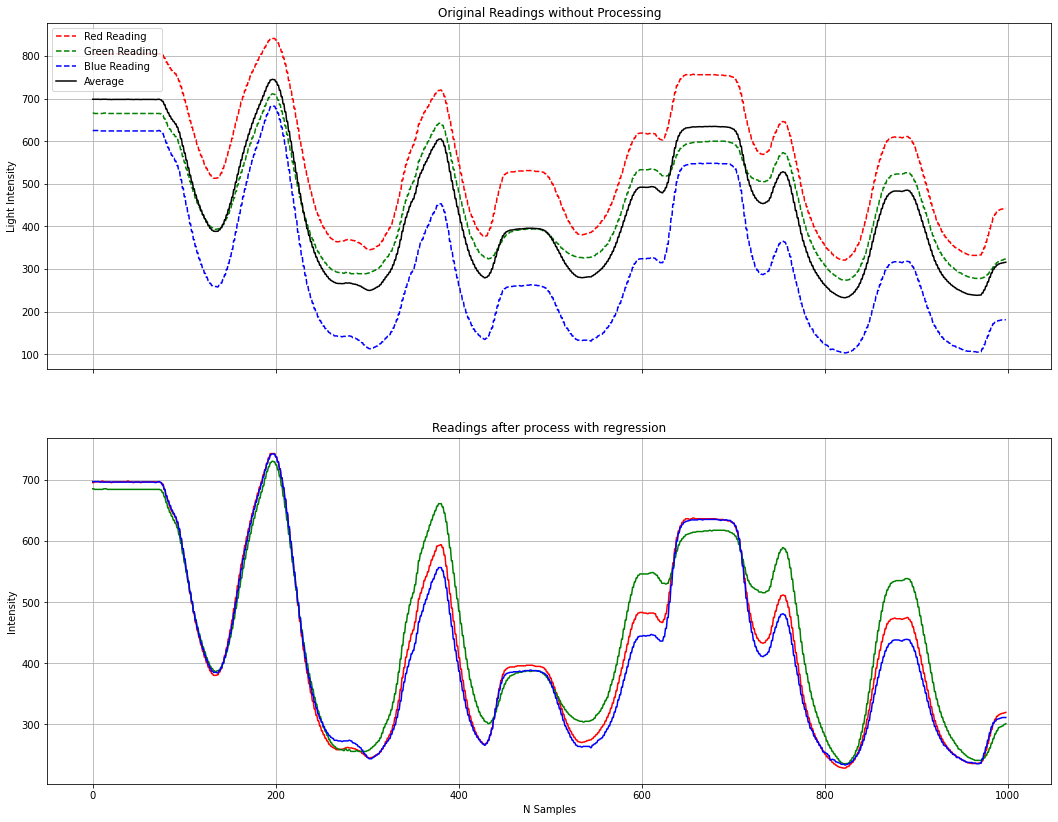

In [57]:
plotReadedData(lgdata, lgaverage)

In [106]:
r = r.astype('int16')

In [112]:
with open('dump.txt', 'w') as dump:
    for index, line in enumerate(r):
        if index % 10 == 0.0:
            dump.write(str(line))
            dump.write("\n")
    